Обучить BERT для задачи классификации. <br>
Взять любой набор данных (например imdb).<br>
Важно рассписать, что именно вы делаете.

В первую очередь, берем данные из csv-файла, кодируем метки negative, positive как 0 и 1 соответственно.<br>
Разделяем выборку на три фрейма: для обучения, валидаии, тестирования.<br>
Качаем предобученный токенизатор для модели BERT (bert-base-cased) и соответствующую модель BERT.<br>
Создаем свою модель с предобученным BERTом внутри. Замораживаем слои BERTа и учим только классификатор из двух линейных слоев. <br>
Используем метод forward() для обучения. Во время обучения будем подавать на вход модели заранее предобработанные BERTом вектора токенов. Это поможет сократить время обучения, т к на каждой эпохе модели не придется прогонять одни и те же токены через BERT, они будут уже предобработанными.<br>
У модели BERT на выходе два тензора: выход последнего скрытого слоя, описывающий состояния токенов, и выход объединенного слоя, содержащий информацию о текстовой последовательности в целом. Поскольку задача - классификация последовательностей текста - используем только второй выход модели.<br>
Применяем метод inference() для тестирования модели. В данном методе токены проходят обработку и BERTом, и классификатором.<br>
Для ускорения работы модели, помимо предобработки BERTом, переносим все тензоры на cuda, сохраняем всю информацию набора данных в файл pt, чтобы при следующих запусках среды иметь возможность считать сохраненные предобработанные данные и сразу использовать.<br>
В процессе токенизации текста получаем три словаря с тензорами.<br>
Тензор input_ids - тензор числовых токенов длиной 512. Незполненные позиции заполняются нулями.<br>
Тензор token_type_ids - численный тип токенов. Если не указывать никакого разделения по типам, тензор будет состоять из нулей.<br>
Тензор attention_mask - маска, обозначающая, какие токены являются значениями по умолчанию (0), а какие использовать как значащие.<br>
Проводим обуение модели в стандартном цикле.

In [ ]:
!pip3 install torcheval
!pip3 install hf_xet


In [2]:
from google.colab import drive
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics import BinaryAccuracy
from torch.nn.utils import clip_grad_norm_
from collections import OrderedDict
from torch.optim import AdamW
from tqdm import tqdm
from torch import nn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import zipfile
import random
import torch
import os


In [3]:
def create_dirs(path: str):
    if not os.path.exists(path):
        os.makedirs(path)


In [4]:
mount_point = '/content/drive'
create_dirs(mount_point)

drive.mount(mount_point, force_remount=True)


Mounted at /content/drive


In [5]:
WORK_FOLDER = '/content/drive/MyDrive/peleng-courses/HW_26'

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.1

BATCH_SIZE = 16


In [6]:
def find_csv(search_dir: str):
    for item in os.listdir(search_dir):
        if item.endswith('csv'):
            return os.path.join(search_dir, item)

    return None


In [7]:
csv_filepath = find_csv(WORK_FOLDER)

if csv_filepath is None:
    for item in os.listdir(WORK_FOLDER):
        item_path = os.path.join(WORK_FOLDER, item)

        if zipfile.is_zipfile(item_path):
            with zipfile.ZipFile(item_path, 'r') as csv_zip:
                csv_zip.extractall(WORK_FOLDER)
            break

    csv_filepath = find_csv(WORK_FOLDER)


In [9]:
imdb_df = pd.read_csv(csv_filepath)
imdb_df


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
imdb_df['sentiment'].unique()


array(['positive', 'negative'], dtype=object)

In [10]:
imdb_df['labels'] = (imdb_df['sentiment'] == 'positive').astype(int)
imdb_df


,review,sentiment,labels
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
...,...,...,...
49995,I thought this movie did a down right good job...,positive,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0
49997,I am a Catholic taught in parochial elementary...,negative,0
49998,I'm going to have to disagree with the previou...,negative,0


In [11]:
# split all samples into train, validation, test
indices = list(imdb_df.index)
np.random.shuffle(indices)

train_count = int(len(imdb_df) * TRAIN_SPLIT)
val_count = train_count + int(len(imdb_df) * VAL_SPLIT)

train_indices = indices[:train_count]
val_indices = indices[train_count:val_count]
test_indices = indices[val_count:]

train_df = imdb_df.iloc[train_indices].copy()
val_df = imdb_df.iloc[val_indices].copy()
test_df = imdb_df.iloc[test_indices].copy()

print('Train set length:', len(train_df),
      '\nValidation set length:', len(val_df),
      '\nTest set length:', len(test_df))

assert len(train_df) + len(val_df) + len(test_df) == len(imdb_df), '[WARNING] Wrong set split'


Train set length: 35000 
Validation set length: 5000 
Test set length: 10000


In [12]:
# initialize tokenizer and BERT model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = BertModel.from_pretrained('bert-base-cased')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
bert_model


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# create custom class for model with BERT
class BertCustom(nn.Module):
    def __init__(self, bert_inner_model):
        super(BertCustom, self).__init__()
        self.inner_model = bert_inner_model

        for param in self.inner_model.parameters():
            param.requires_grad = False

        self.binary_classifier = nn.Sequential(OrderedDict([
            ('dropout1', nn.Dropout(0.2)),
            ('fc1', nn.Linear(768, 256)),
            ('relu', nn.ReLU()),
            ('dropout2', nn.Dropout(0.2)),
            ('fc2', nn.Linear(256, 1)),
            ('sig', nn.Sigmoid())
        ]))

    def forward(self, x):
        x = self.binary_classifier.dropout1(x)
        x = self.binary_classifier.fc1(x)
        x = self.binary_classifier.relu(x)
        x = self.binary_classifier.dropout2(x)
        x = self.binary_classifier.fc2(x)
        x = self.binary_classifier.sig(x)

        return x

    def inference(self, ids, mask):
        x = self.inner_model(input_ids=ids, attention_mask=mask)[1]
        x = self.forward(x)

        return x


In [ ]:
# initialize custom model
custom_model = BertCustom(bert_model)
custom_model.to('cuda')
custom_model


BertCustom(
  (inner_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
# create tokens
train_tokens = bert_tokenizer(train_df['review'].tolist(), padding=True,
                              truncation=True, return_tensors='pt')
val_tokens = bert_tokenizer(val_df['review'].tolist(), padding=True,
                            truncation=True, return_tensors='pt')
test_tokens = bert_tokenizer(test_df['review'].tolist(), padding=True,
                             truncation=True, return_tensors='pt')


In [14]:
# visualize tokens content
for key, vals in train_tokens.items():
    print(f'{key}:\n{vals[0]}\n{vals[0].shape}\n')


input_ids:
tensor([  101,  1188,  1108,  1122,   106,   178,  1156,  1138,  1309,  2637,
         1103,  3830,  1191,   178,  1238,   112,   189,  1640,  1221,  1103,
         1481,  1103,  4429,  4333,   119,   133,  9304,   120,   135,   133,
         9304,   120,   135,  1109,  1141,  1645,  1115,   178,  5687,  1108,
         1115,  1725,  1108, 10822,  5866,  1228,  1105,  1136,  2586, 18467,
          119,   178,  4819,  1123,   178,  1156,  1897,  1123,  1959,  2939,
         1115, 10822,   112,   188,   119,  1184,  1108,  6276,  1110,  1115,
         1107,  1103,  2741,  1187,  9415,  1197,  1110,  2939,  1158,  1113,
         1103,  2704,  1908,  1105,   153, 26930,  1108,  6675,  1118,  1123,
         1334,   178,  1408,  6675,  1315, 25338,  1233,   119,  1120,  1103,
         1159,  1115,  1142,  4086,   178,  1108,  1164,  1275,  7490,  1105,
         1139,  5095,  1959,  1108, 12558,  1121,  1103,  2150,  1177,   178,
         1108,  2157,  1106,  1991,  1191,  1131,  83

In [ ]:
# preprocess tokens, get BERT outputs for using in train

@torch.no_grad
def preprocess_input(bert_model, batch_size, x):
    set_len = len(x['input_ids'])
    x_cuda_ids = x['input_ids'].to('cuda')
    x_cuda_mask = x['attention_mask'].to('cuda')
    bert_model.to('cuda')
    bert_model.eval()

    x_out = torch.tensor([], device='cuda')
    for first_idx in tqdm(range(0, set_len, batch_size)):
        second_idx = min(first_idx + batch_size, set_len)
        x_slice_ids = x_cuda_ids[first_idx:second_idx]
        x_slice_mask = x_cuda_mask[first_idx:second_idx]

        bert_out = bert_model(x_slice_ids, x_slice_mask)[1]
        if x_out.size()[0] == 0:
            x_out = bert_out
        else:
            x_out = torch.vstack((x_out, bert_out))

    return x_out


In [ ]:
# preprocess training and validation set with BERT

train_post = preprocess_input(custom_model.inner_model, BATCH_SIZE, train_tokens)
print('\t', train_post.shape)

val_post = preprocess_input(custom_model.inner_model, BATCH_SIZE, val_tokens)
print('\t', val_post.shape)


100%|██████████| 2188/2188 [19:31<00:00,  1.87it/s]


	 torch.Size([35000, 768])


100%|██████████| 313/313 [02:47<00:00,  1.87it/s]

	 torch.Size([5000, 768])


In [ ]:
data_file_pt = os.path.join(WORK_FOLDER, 'all_data_cuda.pt')


In [ ]:
# save preprocessed tran and val tokens, test tokens and all labels in pt-file

test_ids_cuda = test_tokens['input_ids'].to('cuda')
test_mask_cuda = test_tokens['attention_mask'].to('cuda')

train_labels = torch.tensor(train_df['labels'], dtype=torch.float32).to('cuda')
val_labels = torch.tensor(val_df['labels'], dtype=torch.float32).to('cuda')
test_labels = torch.tensor(test_df['labels'], dtype=torch.float32).to('cuda')

torch.save({'train_set_post': train_post,
            'val_set_post': val_post,
            'test_tokens_ids': test_ids_cuda,
            'test_tokens_mask': test_mask_cuda,
            'train_labels': train_labels,
            'val_labels': val_labels,
            'test_labels': test_labels},
           data_file_pt)


In [ ]:
# load saved data from pt-file to cuda

data_cuda = torch.load(data_file_pt, map_location='cuda')
train_post = data_cuda.get('train_set_post')
val_post = data_cuda.get('val_set_post')
test_ids_cuda = data_cuda.get('test_tokens_ids')
test_mask_cuda = data_cuda.get('test_tokens_mask')
train_labels = data_cuda.get('train_labels')
val_labels = data_cuda.get('val_labels')
test_labels = data_cuda.get('test_labels')

print('Training set shape:', train_post.shape,
      '\nValidation set shape:', val_post.shape,
      '\n\nTest input_ids shape:', test_ids_cuda.shape,
      '\nTest annotation_mask shape:', test_mask_cuda.shape,
      '\n\nTrain labels shape:', train_labels.shape,
      '\nValidation labels shape:', val_labels.shape,
      '\nTest labels shape:', test_labels.shape)


Training set shape: torch.Size([35000, 768]) 
Validation set shape: torch.Size([5000, 768]) 

Test input_ids shape: torch.Size([10000, 512]) 
Test annotation_mask shape: torch.Size([10000, 512]) 

Train labels shape: torch.Size([35000]) 
Validation labels shape: torch.Size([5000]) 
Test labels shape: torch.Size([10000])


In [ ]:
# create custom Dataset class for training
class TrainTokensDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [ ]:
# create custom Dataset class for testing
class TestTokensDataset(Dataset):
    def __init__(self, x_ids, x_mask, y):
        self.x_ids = x_ids
        self.x_mask = x_mask
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_ids[idx], self.x_mask[idx], self.y[idx]


In [ ]:
# create Datasets and DataLoaders objects
train_dataset = TrainTokensDataset(train_post, train_labels)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

val_dataset = TrainTokensDataset(val_post, val_labels)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=BATCH_SIZE)

test_dataset = TestTokensDataset(test_ids_cuda, test_mask_cuda, test_labels)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)


In [ ]:
# create optimizer and loss function
optimizer = AdamW(custom_model.binary_classifier.parameters(), lr=0.001)
loss_fn = nn.BCELoss()


In [ ]:
# general training loop
def train_loop(model, max_epochs, train_loader, val_loader, loss_fn,
               optimizer, best_model_path):
    metric = BinaryAccuracy(threshold=0.5)
    best_acc = None

    history = {'loss': list(), 'val_loss': list(),
               'accuracy': list(), 'val_accuracy': list()}

    for e in range(max_epochs):
        print(f'\nEpoch {e}/{max_epochs}', end='\t')
        epoch_loss = 0
        epoch_acc = 0

        model.train()
        for bert_out, target in tqdm(train_loader):
            optimizer.zero_grad()
            pred = model(bert_out).squeeze()

            step_loss = loss_fn(pred, target)
            epoch_loss += step_loss.item()

            metric.update(pred, target)
            epoch_acc += metric.compute().item()

            step_loss.backward()

            optimizer.step()

        epoch_loss /= len(train_loader)
        epoch_acc /= len(train_loader)

        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)

        print(f'train_loss {epoch_loss}', end='\t')
        print(f'train_acc {epoch_acc}', end='\t')

        val_epoch_loss = 0
        val_epoch_acc = 0

        model.eval()
        with torch.no_grad():
            for bert_out, val_target in val_loader:
                val_pred = model(bert_out).squeeze()
                val_step_loss = loss_fn(val_pred, val_target)
                val_epoch_loss += val_step_loss.item()

                metric.update(val_pred, val_target)
                val_epoch_acc += metric.compute().item()

            val_epoch_loss /= len(val_loader)
            val_epoch_acc /= len(val_loader)

            history['val_loss'].append(val_epoch_loss)
            history['val_accuracy'].append(val_epoch_acc)

            if best_acc is None or val_epoch_acc < best_acc:
                torch.save({'model': model}, best_model_path)

            print(f'val_loss {val_epoch_loss}', end='\t')
            print(f'val_acc {val_epoch_acc}', end='')

    return history


In [ ]:
# make training
EPOCHS = 20
best_model_path = os.path.join(WORK_FOLDER, 'best_bert.pt')

history = train_loop(custom_model, EPOCHS, train_loader, val_loader, loss_fn,
                     optimizer, best_model_path)


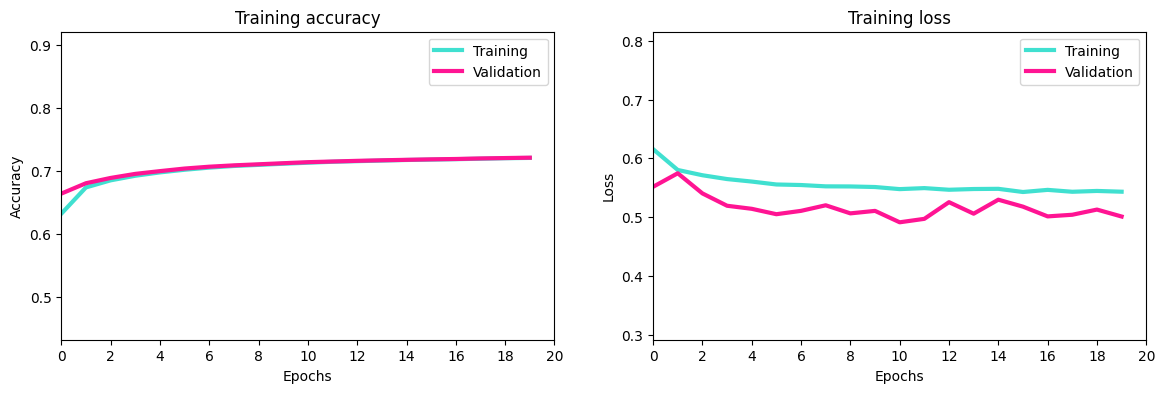

In [ ]:
# show training curve
metrics = ['Accuracy', 'Loss']
plt.figure(figsize=(14, 4))

for i, metric in enumerate(metrics):
    plt.subplot(1, 2, i + 1)
    plt.title(f'Training {metric.lower()}')
    plt.plot(history[f'{metric.lower()}'], color='turquoise', linewidth=3)
    plt.plot(history[f'val_{metric.lower()}'], color='deeppink', linewidth=3)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.1))
    plt.xlabel('Epochs')
    plt.ylabel(f'{metric}')
    plt.legend(['Training', 'Validation'])

    min_val = min(history[f'{metric.lower()}'] \
                  + history[f'val_{metric.lower()}'])
    max_val = max(history[f'{metric.lower()}'] \
                  + history[f'val_{metric.lower()}'])
    min_val = max(min_val - 0.2, 0)

    plt.ylim(min_val, max_val + 0.2)
    plt.xlim(0, EPOCHS)

plt.show()


In [ ]:
# load best trained model to cuda
best_custom_model = torch.load(best_model_path, weights_only=False,
                               map_location='cuda').get('model')


In [ ]:
# test best model
best_custom_model.eval()
avg_loss = 0
avg_acc = 0

metric = BinaryAccuracy(threshold=0.5)
with torch.no_grad():
    for ids, mask, target in tqdm(test_loader):
        pred = best_custom_model.inference(ids, mask).squeeze()
        step_loss = loss_fn(pred, target)
        avg_loss += step_loss.item()

        metric.update(pred, target)
        avg_acc += metric.compute().item()

    avg_loss /= len(test_loader)
    avg_acc /= len(test_loader)

    print(f'test_loss {avg_loss}', end='\t')
    print(f'test_acc {avg_acc}', end='')


100%|██████████| 625/625 [05:17<00:00,  1.97it/s]

test_loss 0.5008236643314361	test_acc 0.7685241439819336

В процессе обучения точность на тестовой выборке составила 0.7685.